In [1]:
import numpy as np
from collections import UserList, UserDict
import networkx as network
import heapq as hq
from itertools import combinations
from matplotlib import patches
from scipy.spatial import ConvexHull, Delaunay
from matplotlib import pyplot as plt

In [10]:
class helper: 
    def __init__(self):
        self.x = 0
        self.y = 0
        
    def plot_polygons(self, env, path=None, scatter_points=None):
        fig, ax = plt.subplots()
        x = shape_defs.to_patches_polygon()
        patches = self.mapl(lambda poly: poly.to_patches_polygon(), env)
        p = PatchCollection(patches, cmap=matplotlib.cm.jet, alpha=0.9)
        colors = 100*np.random.rand(len(patches))
        p.set_array(np.array(colors))

        major_ticks_x = np.arange(0, 801, 25)
        major_ticks_y = np.arange(0, 301, 25)
        plt.gca().invert_yaxis()
        ax.add_collection(p)
        ax.set_xticks(major_ticks_x)
        ax.set_yticks(major_ticks_y)    
        ax.xaxis.tick_top()

        if path is not None:
            plt.plot(path[:, 0], path[:, 1], c='red', label='Shortest Path')
        if scatter_points is not None:
            plt.scatter(scatter_points[:, 0], scatter_points[:, 1], label='Nodes')

        if path is not None or scatter_points is not None:
            plt.legend()
        plt.show()
    
    def euclidean_dist(x1, x2):
        return np.linalg.norm(np.array(x1) - np.array(x2))


    def mapl(f, *seq):
        return list(map(f, *seq))


    def timed(f):
        def wrapper(*args, **kwargs):
            start = time.time()
            ret = f(*args, **kwargs)
            end = time.time()

            return ret, (end - start)

        return wrapper


    def sample_edge(v1, v2, num_samples=20, theta=None):
            sample_points = []
            x1, y1 = v1
            x2, y2 = v2
            if np.isclose((x2 - x1), 0):
                x = [x1] * num_samples
                y = np.arange(y1, y2, (y2 - y1) / num_samples)
            else:
                m = (y2 - y1) / (x2 - x1)
                c = y1 - (m * x1)
                x = np.arange(x1, x2, (x2 - x1) / num_samples)
                y = m * x + c
            if theta is not None:
                thetas = [theta] * num_samples
                for p in zip(x, y, thetas):
                    sample_points.append(p)
            else:
                for p in zip(x, y):
                    sample_points.append(p)
            return sample_points


    def nearest5(x):
        return round(x / 5) * 5


    def sigmoid(x):
        return 1 / (1 + np.exp(-x))


    ADJ_S = {0: (1, 0), 5: (11, 1), 10: (6, 1), 15: (4, 1), 20: (3, 1), 25: (2, 1), 30: (9, 5), 35: (3, 2), 40: (6, 5), 45: (1, 1),
             50: (5, 6), 55: (2, 3), 60: (5, 9), 65: (1, 2), 70: (1, 3), 75: (1, 4), 80: (1, 6), 85: (1, 11), 90: (0, 1)}
    def adjacent_square(x, y, theta):
        ax, ay = ADJ_S[theta]
        return x + ax, y + ay

In [11]:
# Class definition for shapes used in the configuration space
# For the given problem, the shapes are just rectangles with pointed edges for different angles
class shape_defs(object):
    # Constructor of the class
    def __init__(self, vertices):     
        self.hull = None
        self.vertices = np.array(vertices)  #Convert the input array to matrix form
        self.sort_vertices()
    
    # Sorts the vertices based on the angle between the x and y co-ordinates
    def sort_vertices(self):
        centroid = np.mean(self.vertices, axis=0)
        centered_vertices = self.vertices - centroid
        angles = [np.arctan2(v[1], v[0]) for v in centered_vertices]

        temp = list(sorted(enumerate(self.vertices), key=lambda t: angles[t[0]]))
        sorted_vertices = np.array(helper.mapl(lambda tupl: tupl[1], temp))
        self.vertices = sorted_vertices
    
    # Helper function to account for the robot's angle
    # Takes in the input of angle and applies rotation matrix to the given vertices
    def rotated_vertices(self, angle):
        theta = np.deg2rad(angle)
        centroid = np.mean(self.vertices, axis=0)
        centered_vertices = self.vertices - centroid
        # 2D rotation matrix - https://en.wikipedia.org/wiki/Rotation_matrix
        R = np.array([[np.cos(theta), -np.sin(theta)],
                      [np.sin(theta), np.cos(theta)]])
        vertices = np.matmul(R, centered_vertices.T).T
        vertices += centroid
        return vertices
    
    # Helper function to create and use polygons from the given patches
    # Utilizes patches library of matplotlib
    def to_patches_polygon(self):
        self.angular_sort_vertices()
        print(self.vertices)
        return patches.Polygon(self.vertices)

    # Method to check if the given input "point" is present inside the shape
    # This method utilizes the library function Delaunay defined in scipy
    # Returns a boolean value of True if the point is present within the shape
    def shape_has(self, point):
        if self.hull is None:
            self.hull = Delaunay(self.vertices)
        return self.hull.find_simplex(point) >= 0    

In [12]:
# Robot environment class
class robot_environment(UserList):
    #Constructor that creates the polygons in the given robot environment
    def __init__(self, polygons):
        self.data = polygons
      
    #Classes related to the environment
    def check_in_polygon(self, point):
        for obstacle in self.data:
            if point in obstacle:
                return True
        return False

In [13]:
# Graph datastructure for the environment

class Graph(UserDict):
    def __init__(self, graph):
        self.data=graph
        self.vertexset = set()
    
    def add_edge(self, point1, point2, w):
        t1, t2 = tuple(p1), tuple(p2)
        self.data[t1][t2] = w
    
    def populate_vset(self, cspace, thetas):
        for i, plane in enumerate(cspace):
            theta = thetas[i]
            for vertex in plane:
                self.vertexset.add((vertex[0], vertex[1], theta))
    
    def all_vertices(self):
        if self.vset is not None:
            self.vertexset = set()
            for key in self.data:
                self.vertexset.add(key)
                for inner_key in self.data[key]:
                    self.vertexset.add(inner_key)
        return self.vertexset

In [14]:
class Rectangle(shape_defs):
    def __init__(self, points, width, height):
        self.points = points
        self.width = width
        self.height = height
        vertices = []
        for x in range(width):
            for y in range(height):
                vertices.append([points[0] + x, points[1] + y])
        
        shape_defs(vertices) #Could be the source of the problem

# Define the environment

In [15]:
helper_func = helper()
top = Rectangle([0, 0], 800, 1)
bottom = Rectangle([0, 299], 800, 1)
left = Rectangle([0, 0], 1, 300)
right = Rectangle([799, 0], 1, 300)
wall1 = Rectangle([200, 0], 1, 200)
wall2 = Rectangle([100, 199], 200, 1)
wall3 = Rectangle([400, 100], 1, 200)
wall4 = Rectangle([600, 0], 1, 200)
wall5 = Rectangle([500, 199], 200, 1)

env = robot_environment([top, bottom, left, right, wall1, wall2, wall3, wall4, wall5])

TypeError: to_patches_polygon() missing 1 required positional argument: 'self'

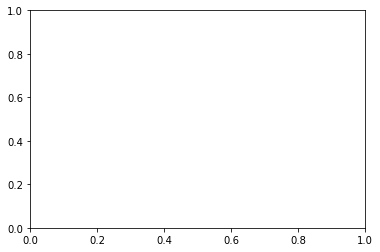

In [16]:
helper_func.plot_polygons(env)